# Optimizers
> All is one

We're going to replace the Pytorch Optim with a custom optimizer class that uses `steppers`.

This will allow us to make one Optimizer that can do any type of step we want to define. 

It can do a SGD step, a momentum step, a weight decay step, or an Adam step. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_09a import *

## Imagenette Data

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160) # downloads and returns a path to folder
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor] # transforms to be applied to images

bs = 128

il = ImageList.from_files(path, tfms=tfms) # Imagelist from files
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name="val")) # Splitdata by function
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcesser()) # label the data by parent folder
data = ll.to_databunch(bs, c_in=3, c_out=10)

In [4]:
nfs = [32,64,128,256]

In [5]:
callbacks = [partial(AvgStatsCallback, accuracy),
            CudaCallback, 
            partial(BatchTransformXCallback, norm_imagenette)]

In [6]:
learn, run = get_learn_run(data, nfs,conv_layer, 0.3,  cbs=callbacks)

Baseline single epoch validation accuracy with vanilla Stochastic Gradient Descent (SGD):

In [7]:
run.fit(1, learn)

train: [1.7680847122848242, tensor(0.3930, device='cuda:0')]
valid: [1.5259199591958599, tensor(0.4828, device='cuda:0')]


## Refining the Optimizer

The `param_groups` is a list of lists:

``` python
self.param_groups = [[pg1], [pg2], [pg3]]
    
```    
Each `param_group` will have a corresponding hyperparameter dictionary in the list `self.hyper`:
``` python
self.hyper = [{'lr': 0.2,'wd':0.}, {'lr': 0.1,'wd':0.}, {'lr': 0.4,'wd':0.}]
``` 

In [8]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.param_groups = list(params)
        
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): 
            self.param_groups = [self.param_groups]
        
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers) for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p,hyper in self.grad_params(): # iterates through 
            p.grad.detach_() # removes gradient computation history
            p.grad.zero_() # zeros the grads for next batch
            
    def step(self):
        for p, hyper in self.grad_params(): # does nothing without steppers
            compose(p, self.steppers, **hyper)

### SGD

__Step__: Add the negative learning rate to the gradient of the parameter.

In [9]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [10]:
opt_func = partial(Optimizer, steppers=[sgd_step])

### Refactor Callbacks

In [11]:
#export
class AvgStats():
    def __init__(self, metrics, in_train):
        self.metrics = listify(metrics)
        self.in_train = in_train

    def reset(self):
        self.tot_loss = 0.
        self.count = 0
        self.tot_mets = [0.]*len(self.metrics)

    @property
    def all_stats(self): 
        return [self.tot_loss.item()] + [o.item() for o in self.tot_mets]
    
    @property
    def avg_stats(self): 
        return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return "Something went wrong: count is zero."
        if self.in_train:
            return f"Train: {[round(o,4) for o in self.avg_stats]}" 
        else:
            return f"Valid: {[round(o,4) for o in self.avg_stats]}\n"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i, m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats = AvgStats(metrics, True)
        self.valid_stats = AvgStats(metrics, False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

`Recorder` will have to be re-written to work with this new optimizer. We had pulling everything from Pytorch's `opt.param_groups`

In [12]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.losses = []
        self.lrs = []

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_loss(self): plt.plot(self.losses)
    def plot_lr  (self): plt.plot(self.lrs)

    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

ParamScheduler:

In [13]:
#export
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs):
        self.pname = pname
        self.sched_funcs = listify(sched_funcs)

    def begin_batch(self):
        if not self.in_train: return # end if not in train mode
        fs = self.sched_funcs # list of scheduler funcs
        if len(fs)==1: # if only 1 scheduler multiple it and use it for each group
            fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs # position in training
        for scheduler, hyper in zip(fs, self.opt.hypers):
            hyper[self.pname] = scheduler(pos) # change the pname according to the scheduler
            

Finally, `LR_Find`:

In [14]:
#export
class LR_Find(Callback):
    _order = 1

    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = 1e9

    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr # change from opt.param_groups
 
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException
        if self.loss < self.best_loss:
            self.best_loss = self.loss

In [15]:
sched = combine_scheds([.3, .7], [sched_cos(.3, .8), sched_lin(.8, 0.1)])

In [16]:
callbacks = [partial(AvgStatsCallback, accuracy),
             CudaCallback, Recorder, 
             partial(ParamScheduler, 'lr', sched)]

In [17]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.3,  cbs=callbacks, opt_func=opt_func)

In [18]:
run.fit(1, learn)

Train: [1.8778, 0.3577]
Valid: [1.482, 0.5052]



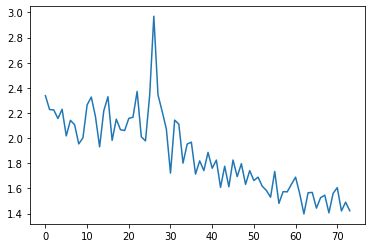

In [19]:
run.recorder.plot_loss()

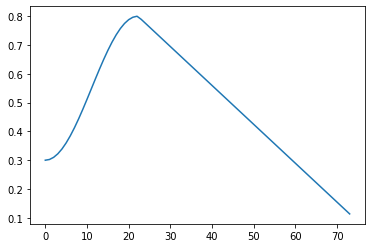

In [20]:
run.recorder.plot_lr()

## Weight Decay

Limiting our weights from growing too much is going to hinder the training of the model, but it will yield to a state where it generalizes better. Going back to the theory a little bit, weight decay (or just `wd`) is a parameter that controls that sum of squares we add to our loss:
``` python
loss_with_wd = loss + (wd/2) * (weights**2).sum()
```

In practice though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high school math, the derivative of `p**2` with respect to `p` is `2*p`. So adding that big sum to our loss is exactly the same as doing:
``` python
weight.grad += wd * weight
```

for every weight in our model, which in the case of vanilla SGD is equivalent to updating the parameters with:
``` python
weight = weight - lr*(weight.grad + wd*weight)
```

This technique is called "weight decay", as each weight is decayed by a factor `lr * wd`, as it's shown in this last formula.

This only works for standard SGD, as we have seen that with momentum, RMSProp and Adam, the update has some additional formulas around the gradient. In those cases, the formula that comes from L2 regularization:
``` python
weight.grad += wd * weight
```
is different than weight decay
``` python
new_weight = weight - lr * weight.grad - lr * wd * weight
```

Most libraries use the first one, but as it was pointed out in [Decoupled Weight Regularization](https://arxiv.org/pdf/1711.05101.pdf) by Ilya Loshchilov and Frank Hutter, it is better to use the second one with the Adam optimizer, which is why fastai made it its default.

In [ ]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1-lr*wd)
    return p

weight_decay._defaults = dict(wd=0.)

L2 Regularization:

In [ ]:
#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data) # scalar times parameter and then add to gradient 
    return p

l2_reg._defaults = dict(wd=0.)

## Momentum

## Adam

## Lamb

In [ ]:
nb_auto_export()